**Name: Sumit Kalamkar | Roll no:27 | PRN: 22SC114501083 | Div:B**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score

In [3]:
!pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 1.3 MB/s eta 0:00:00


In [4]:
import warnings
warnings.filterwarnings("ignore")


In [5]:
from fairlearn.metrics import (
    MetricFrame,
    true_positive_rate,
    false_positive_rate,
    false_negative_rate,
    selection_rate
)

In [18]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", header=None)


In [19]:
column_names = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]

df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None,
    names=column_names,
    na_values=" ?",  # Optional: treat missing values properly
    skipinitialspace=True
)


In [20]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


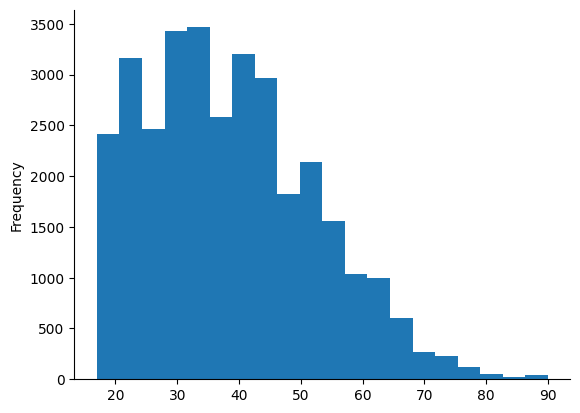

In [10]:
# @title 0

from matplotlib import pyplot as plt
df[0].plot(kind='hist', bins=20, title=0)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [21]:
df.dropna(inplace=True)
df = df[(df['race'] == 'White') | (df['race'] == 'Black')]  # filter to two groups for simplicity
df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

In [23]:
X = df.drop(columns=['income'])
y = df['income']


X_encoded = pd.get_dummies(X, drop_first=True)


X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


race_test = X_test['race_Black'] if 'race_Black' in X_test.columns else pd.Series([0]*len(X_test))


In [25]:
X

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States


In [26]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [27]:
y_pred

array([0, 0, 1, ..., 0, 1, 0])

In [28]:
metric_frame = MetricFrame(
    metrics={
        'TPR': true_positive_rate,
        'FPR': false_positive_rate,
        'FNR': false_negative_rate,
        'Selection Rate': selection_rate
    },
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=race_test
)

print("📊 Fairness Metrics BEFORE SMOTE:\n", metric_frame.by_group)

📊 Fairness Metrics BEFORE SMOTE:
                           TPR       FPR       FNR  Selection Rate
sensitive_feature_0                                              
0                    0.623026  0.071551  0.376974        0.207014


In [29]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)


clf_smote = RandomForestClassifier(random_state=42)
clf_smote.fit(X_train_bal, y_train_bal)
y_pred_smote = clf_smote.predict(X_test)

In [30]:
y_pred_smote

array([0, 0, 1, ..., 0, 1, 0])

In [31]:
metric_frame_smote = MetricFrame(
    metrics={
        'TPR': true_positive_rate,
        'FPR': false_positive_rate,
        'FNR': false_negative_rate,
        'Selection Rate': selection_rate
    },
    y_true=y_test,
    y_pred=y_pred_smote,
    sensitive_features=race_test
)

In [32]:
print("Fairness Metrics AFTER SMOTE:\n", metric_frame_smote.by_group)


print("\nAccuracy Before SMOTE:", accuracy_score(y_test, y_pred))
print("Accuracy After SMOTE:", accuracy_score(y_test, y_pred_smote))

Fairness Metrics AFTER SMOTE:
                           TPR       FPR       FNR  Selection Rate
sensitive_feature_0                                              
0                    0.659868  0.090189  0.340132        0.230123

Accuracy Before SMOTE: 0.8534259857789269
Accuracy After SMOTE: 0.8484162895927602


📉 Before SMOTE:

| Metric         | Value      |
| -------------- | ---------- |
| TPR            | 0.6230     |
| FPR            | 0.0715     |
| FNR            | 0.3770     |
| Selection Rate | 0.2070     |
| **Accuracy**   | **85.34%** |


🟡 Interpretation:

The model is more accurate, but less fair.

Only 20.7% of the group is selected (i.e., receives a positive prediction).

The model misses ~37.7% of actual positives (FNR).

📉 After SMOTE:

| Metric         | Value      |
| -------------- | ---------- |
| TPR            | 0.6599     |
| FPR            | 0.0902     |
| FNR            | 0.3401     |
| Selection Rate | 0.2301     |
| **Accuracy**   | **84.84%** |

🟢 Interpretation:

1. TPR improved (from 0.623 to 0.660), meaning the   model catches more actual positives in this group.

2. Selection Rate increased to 23%, meaning more individuals in this group are getting positive predictions.

4. Accuracy slightly decreased, but the model is potentially becoming more fair.